In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!cp -r ./gdrive/MyDrive/Table-Tennis-Analysis/Semantic_Segmentation/* .

Mounted at /content/gdrive


In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()

553467904/553467096 [==============================] - 5s 0us/step


In [ ]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

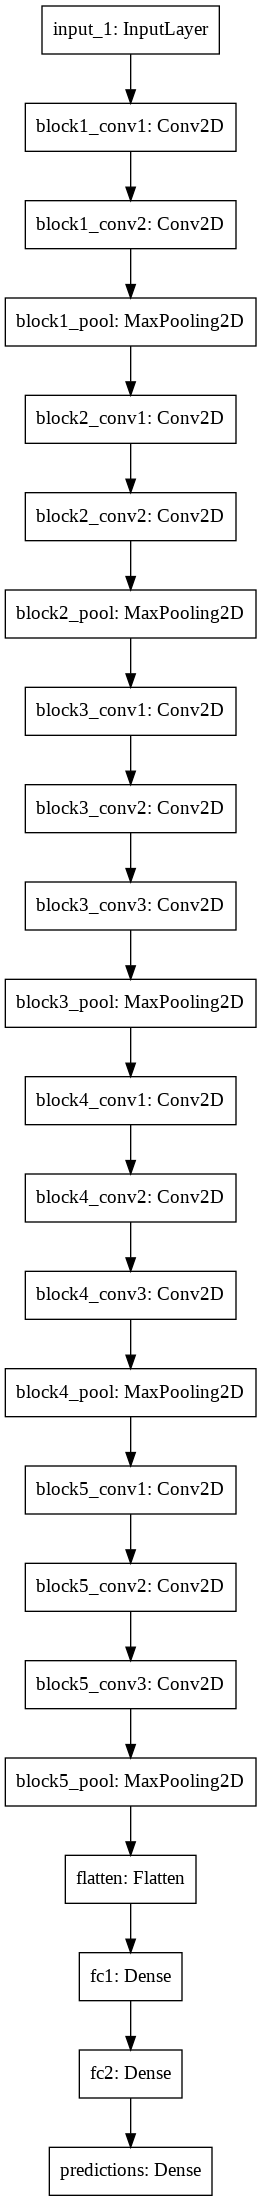

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='vgg.png')

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load an image
image = load_img('mug.jpg', target_size=(224,224))

# convert to numpy array
image = img_to_array(image)

# reshape the array to add the extra dimension (number of samples(inputs))
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

FileNotFoundError: ignored

In [ ]:
from keras.applications.vgg16 import preprocess_input
# preprocess for the VGG model
image = preprocess_input(image)

In [ ]:
# make a prediction
yhat = model.predict(image)

In [ ]:
# interpret the prediction
from keras.applications.vgg16 import decode_predictions
# convert the probs to class labels
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

# START

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!pip3 install segmentation_models_pytorch
# !pip install albumentations
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install imgaug==0.2.7

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-is_u0nfd
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-is_u0nfd
     |████████████████████████████████| 952kB 7.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=88321 sha256=926501d5315981abc125caf1343a3348595f95f4287025df0dce09e94738a677
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ywwqf7h/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.7
    Uninstalling imgaug-0.2.7:
      Successfully uninstalled imgaug-0.2.7
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2
  Using cached https://files.pythonhosted.org/packages/af/fc/c56a7da8c23122b7c5325b941850013880a7a93c21dc95e2b1ecd4750108/imgaug-0.2.7-py3-none-any.whl
ERROR: albumentations 0.5.

In [ ]:
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp
import torch
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import functools


In [ ]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'Tesla T4')

In [ ]:
data_path = 'data/table_segmentation'

x_train_path = os.path.join(data_path, 'train')
x_valid_path = os.path.join(data_path, 'validation')
x_test_path = os.path.join(data_path, 'test')

y_train_path = os.path.join(data_path, 'labels', 'train.csv')
y_valid_path = os.path.join(data_path, 'labels', 'valid.csv')
y_test_path = os.path.join(data_path, 'labels', 'test.csv')

In [ ]:
def image_transpose_exif(im: np.array) -> np.array:
    """Transpose smartphone images that mave be incorrectly oriented.

    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

In [ ]:
class TableDataset(Dataset):
    def __init__(self, csv_file, root_dir, resize=None, transform=None, augmentation=None, copies=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.grid_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.resize = resize
        self.transform = transform
        self.augmentation = augmentation
        self.copies = copies

    def __len__(self):
        if self.copies:
            return self.grid_frame.shape[0] * self.copies
        else:
            return self.grid_frame.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.copies:
            idx = idx % self.grid_frame.shape[0]

        img_name = os.path.join(self.root_dir,
                                self.grid_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image_transpose_exif(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        shape = image.shape
                
        grid = self.grid_frame.loc[idx, 'region_shape_attributes']
        mask = get_mask(grid, shape[:2])
        mask = mask / 255 # normalise
        # mask = np.stack(masks, axis=-1).astype('float')
        
        if self.resize is not None:
            image, mask = cv2.resize(np.uint8(image), (480, 320)), cv2.resize(np.uint8(mask), (480, 320))
            mask = mask.reshape((*mask.shape, 1))
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

def get_mask(row, shape):
    row = json.loads(row)
    coords = np.array([[x,y] for x, y in zip(row['all_points_x'], row['all_points_y'])])
    mask = np.zeros((*shape, 1))
    cv2.fillPoly(mask, [coords], 255)
    return mask

In [ ]:
def visualize(**images):
    """Plot images in a row."""
    n = len(images)
    plt.figure(figsize=(16, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color='white')
        plt.imshow(image)
    plt.show()

In [ ]:
# os.chdir('..')

In [ ]:
# os.getcwd()

In [ ]:
y_train_path

'data/table_segmentation/labels/train.csv'

In [ ]:
grid_dataset = TableDataset(y_train_path, x_train_path, 0.25, copies=2)
len(grid_dataset)

64

In [ ]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100

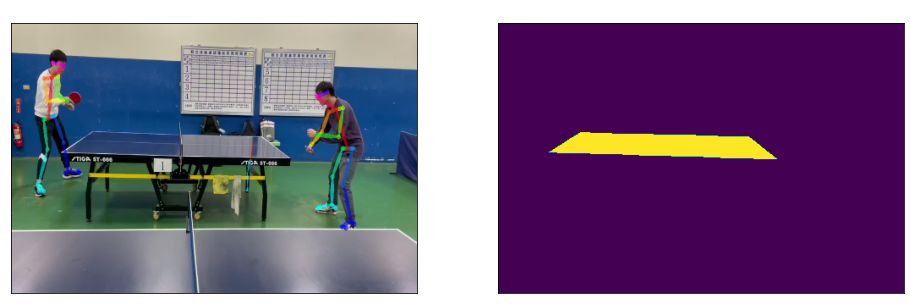

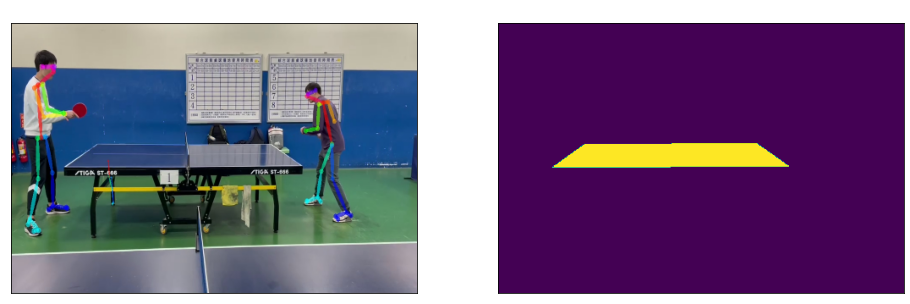

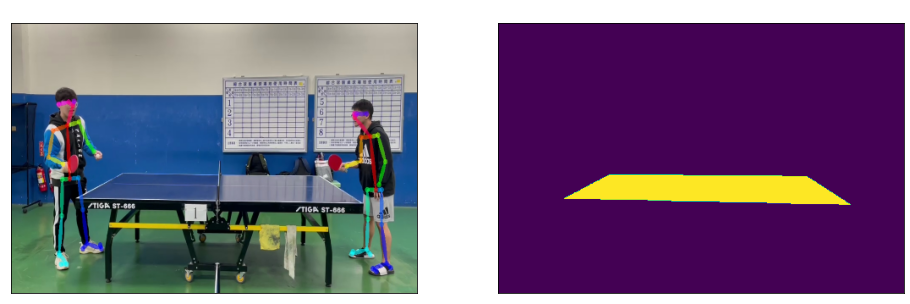

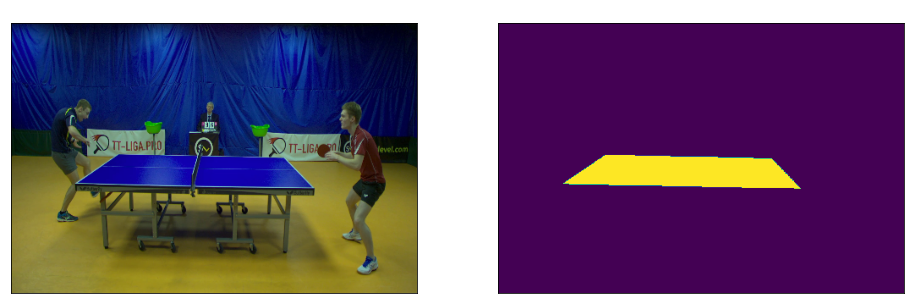

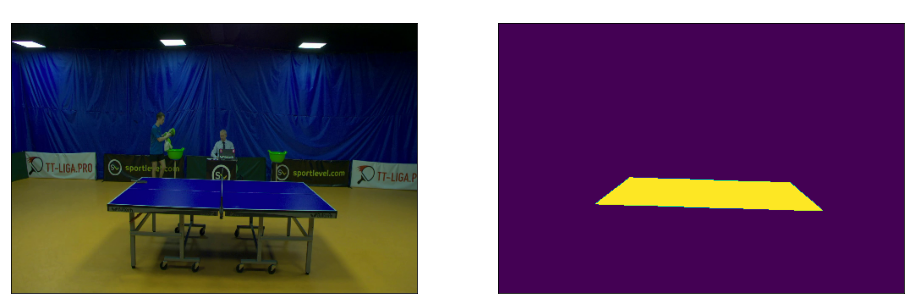

In [ ]:
grid_dataset = TableDataset(y_train_path, x_train_path, True)

for x in range(5):
    # print(x)
    out = grid_dataset[x]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

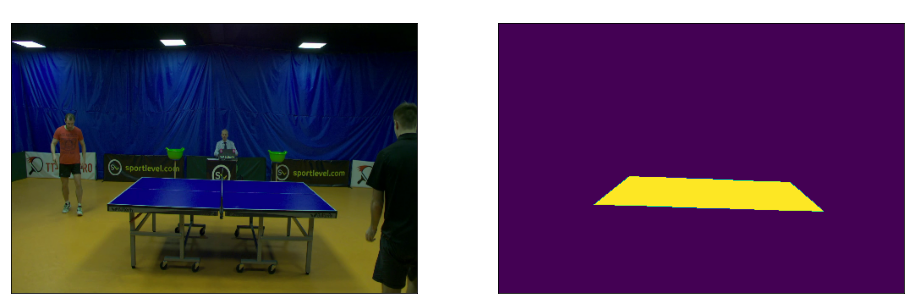

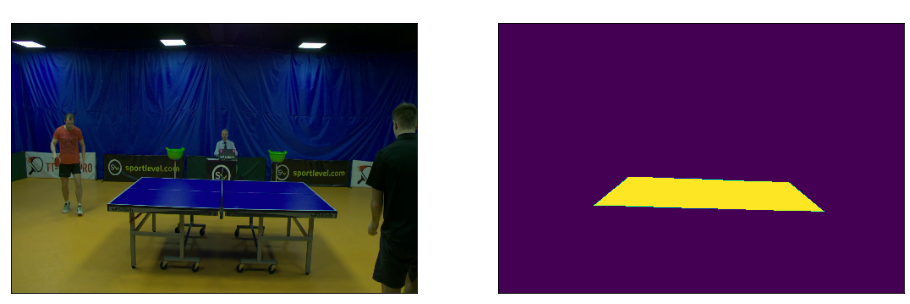

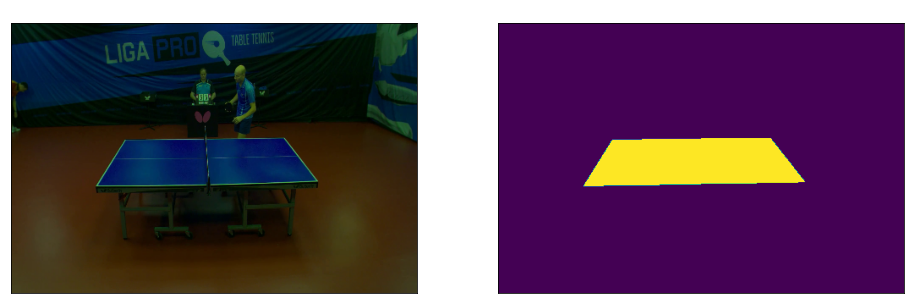

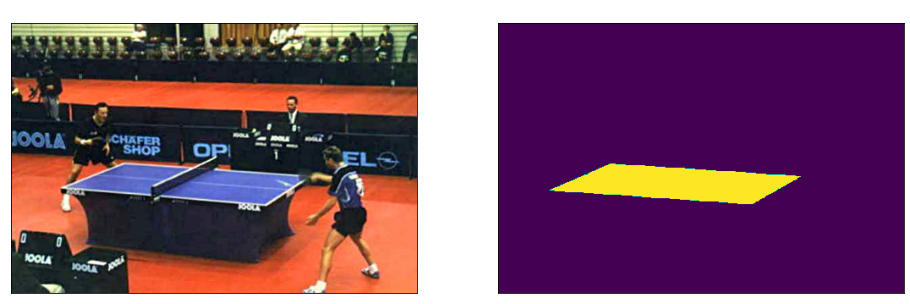

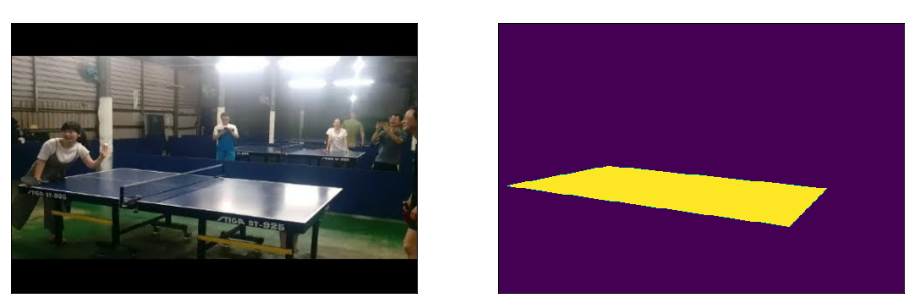

In [ ]:
valid_dataset = TableDataset(y_valid_path, x_valid_path, True)

for x in range(5):
    out = valid_dataset[x]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

# Data Augmentation

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.8, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.1),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:334: FutureWarning: IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


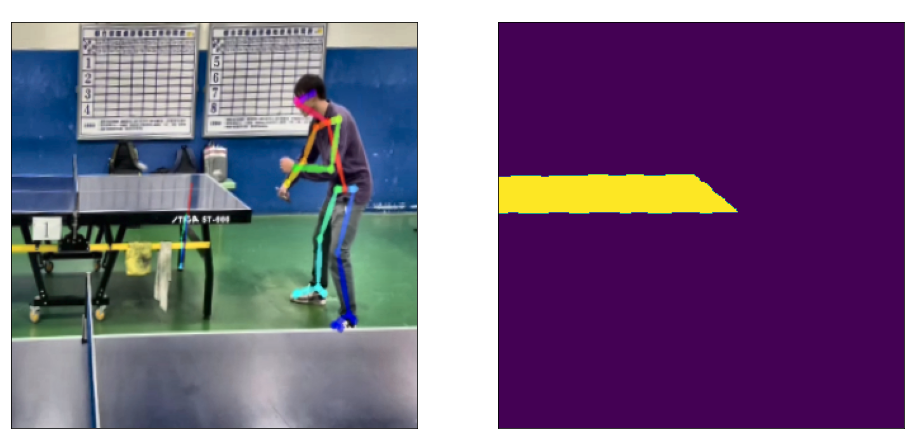

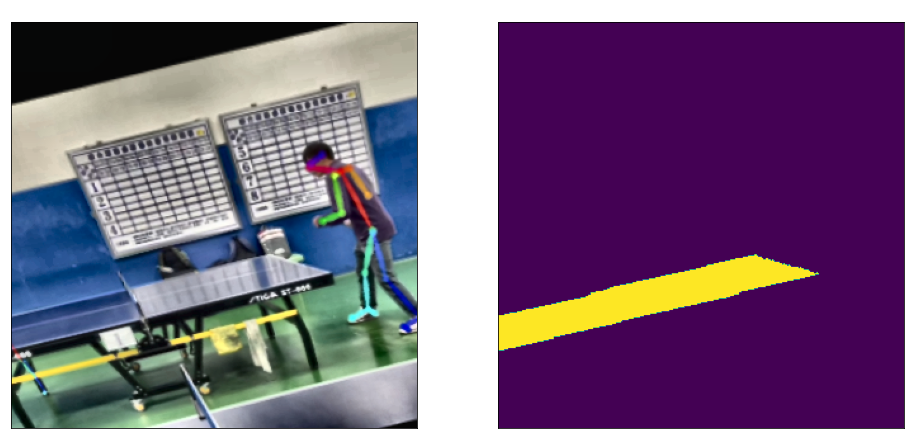

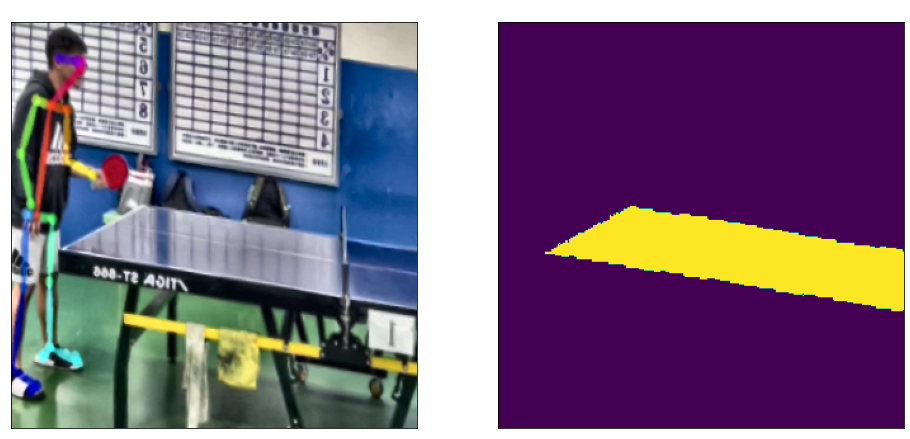

In [ ]:
augmented_dataset = TableDataset(
    y_train_path, x_train_path, resize=True,
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze())

In [ ]:
import gc; gc.collect()

9438

In [ ]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['grid']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device('cuda:0')

In [ ]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to('cuda')

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = TableDataset(y_train_path, x_train_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_training_augmentation(), copies=2)
print('Number of training samples:', len(train_dataset))

valid_dataset = TableDataset(y_valid_path, x_valid_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_validation_augmentation(), copies=1)

Number of training samples: 64


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:334: FutureWarning: IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.CrossEntropyLoss()
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# max_score = 0

# for i in range(0, 40):
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth`')
#         print('Model saved!')
        
#     if i == 15:
#         new_lr = 5e-5
#         optimizer.param_groups[0]['lr'] = new_lr
#         print(f'Decrease decoder learning rate to {new_lr}!')

In [ ]:
import torch
model = torch.load('./best_model_2.pth').to('cuda')

# Visualize the predictions

In [ ]:
test_dataset = TableDataset(
    y_test_path, x_test_path, resize=True,
    augmentation=get_validation_augmentation(), 
    transform=get_preprocessing(preprocessing_fn),
    copies=1
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
len(test_dataset)

3

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 3/3 [00:00<00:00,  8.84it/s, dice_loss - 0.6795, iou_score - 0.4853]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = TableDataset(
    y_test_path, x_test_path, # resize=True 
)

In [ ]:
model_cpu = model.to('cpu')

In [ ]:
# time one prediction
%time
torch.no_grad()
image_vis = test_dataset_vis[0][0].astype('uint8')
image, gt_mask = test_dataset[0]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).unsqueeze(0)
pr_mask = model_cpu.predict(x_tensor)
pr_mask = pr_mask.squeeze().numpy().round()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate(input_sample):
    num_frames = input_sample.shape[0]
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(input_sample[0,:,:,:])

    def update(i):
        img = input_sample[i,:,:,:]
        im.set_data(img)
        return im

    ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False, interval=60)  
    return ani


In [ ]:
# TODO find a way to get the frame rate of the video and calculate the required interval between frames
# TODO scale up to full sized images
import cv2
vidcap = cv2.VideoCapture('./data/table_segmentation/video/TEST2.mp4')
frames_processed = []
success, image_base = vidcap.read()
val_aug = get_validation_augmentation()
count = 0 

while success:    
    image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
    # image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
    image = cv2.resize(image_base, (480, 320))
    frame = val_aug(image=image)['image']
    frame = preprocessing_fn(frame)
    frame = to_tensor(frame)
    
    frame = torch.from_numpy(frame).unsqueeze(0)
    
    pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    pr_mask_full = cv2.resize(pr_mask, (image_base.shape[1], image_base.shape[0]))
    pr_mask_full = np.expand_dims(pr_mask_full, 2)
    
    transparency = 0.4
    pr_mask_full *= transparency

    # make a green overlay
    green = np.ones(image_base.shape, dtype=np.float) * (0,1,0)

    # green over original image
    out = green * pr_mask_full + image_base * (1.0 - pr_mask_full) / 255
    out = np.clip(out, 0, 1)
    frames_processed.append(out)
    
    count += 2
    vidcap.set(1, count)
    success, image_base = vidcap.read()
    
    # if count > 20: break

NameError: ignored

In [ ]:
# frames_processed = np.array(frames_processed)
# ani = animate(frames_processed)
# del frames_processed

In [ ]:
# ani.save('data/table_segmentation/video/TEST2_prediction.mp4')
# del ani

In [ ]:
print(pr_mask_full)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.7592468 0.7592468 0.7592468 ... 0.        0.        0.       ]
 [1.        1.        1.        ... 0.        0.        0.       ]
 [1.        1.        1.        ... 0.        0.        0.       ]]


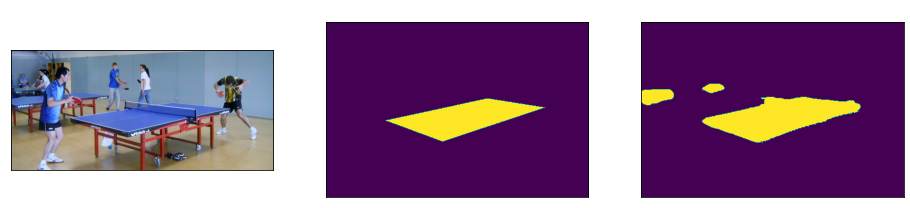

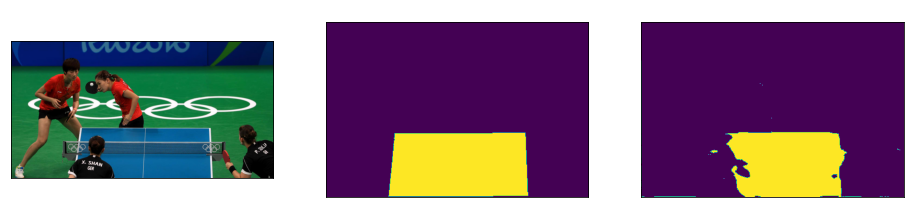

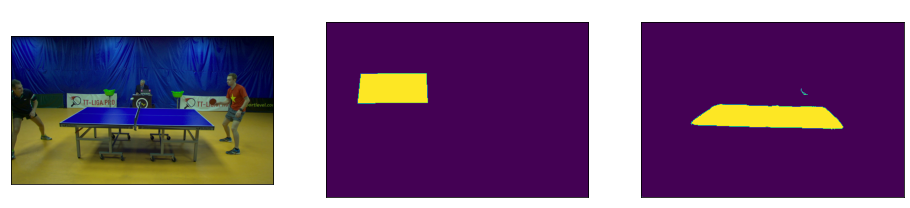

In [ ]:
for i in range(len(test_dataset)):  
    torch.no_grad()
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = model_cpu.predict(x_tensor)
    pr_mask = pr_mask.squeeze().numpy().round()
        
    
    visualize(
        image=image_vis, 
        actual=gt_mask, 
        predicted=pr_mask
    )
    

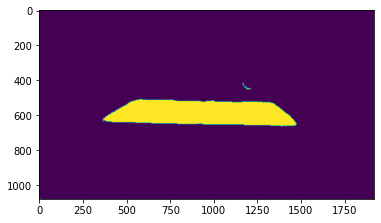

In [ ]:
pr_mask_full = cv2.resize(pr_mask, (image_vis.shape[1], image_vis.shape[0]))
plt.imshow(pr_mask_full)